<a href="https://colab.research.google.com/github/HyungjoByun/Projects/blob/main/Context%20Encoder/ContextEncoder_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch import optim
from torch.utils.tensorboard import SummaryWriter 
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import time


if torch.cuda.is_available():
  device = 'cuda:0'
else:
  device = 'cpu'

In [3]:
if not os.path.isfile("/content/voc_test_2012_tar"):
  !cp "/content/drive/MyDrive/Faster_RCNN/VOCtrainval_11-May-2012.tar" "/content/voc_test_2012_tar" 
  ! tar -xf "/content/voc_test_2012_tar"

[  0   1   2 255]
(256, 256, 3)


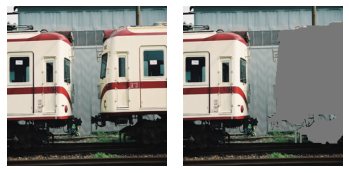

In [4]:
#mask 만들기
fig = plt.figure()

item = 4
original_list = os.listdir("/content/VOCdevkit/VOC2012/JPEGImages/")
original_list.sort()
original_image = Image.open("/content/VOCdevkit/VOC2012/JPEGImages/"+original_list[item])
original_image = original_image.resize((256,256))
np_original = np.array(original_image,dtype=np.uint8)/255
fig.add_subplot(1,2,1)
plt.imshow(np_original)
plt.axis('off')


seg_image = Image.open("/content/VOCdevkit/VOC2012/SegmentationObject/"+original_list[item][:-3]+"png")
seg_image = seg_image.resize((256,256))
np_seg = np.array(seg_image,dtype=np.uint8)
labels = np.unique(np_seg)
print(labels)

np_seg = np.where(np_seg == labels[1],1.0,0)
np_seg = np.stack((np_seg,np_seg,np_seg),axis = 2)
print(np_seg.shape)

masked_image = (1-np_seg)*np_original + np_seg*(np.zeros_like(np_original)+np.mean(np_original))

fig.add_subplot(1,2,2)
plt.imshow(masked_image)
plt.axis('off')

plt.subplots_adjust(wspace=0.1,hspace=0)

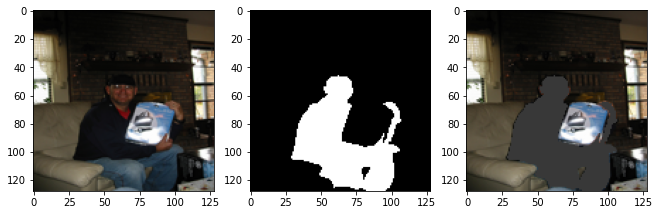

In [5]:
def make_sample(size,batch_size):
  original_list = os.listdir("/content/VOCdevkit/VOC2012/JPEGImages/")

  while True:
    try:
      item = np.random.randint(0,len(original_list))
      original_image = Image.open("/content/VOCdevkit/VOC2012/JPEGImages/"+original_list[item])
      seg_image = Image.open("/content/VOCdevkit/VOC2012/SegmentationObject/"+original_list[item][:-3]+"png")
    except:
      continue

    original_image = original_image.resize((size,size))
    np_original = np.array(original_image,dtype=np.uint8)/255

    seg_image = seg_image.resize((size,size))
    np_seg = np.array(seg_image,dtype=np.uint8)

    labels = np.unique(np_seg)
    label = 0
    for lb in labels[1:-1]:
      if len(np.where(np_seg == lb)[0]) < (size**2)/4:
        label = lb
        break

    if label != 0:
      break
  
  np_seg = np.where(np_seg == labels[1],1.0,0)
  np_seg = np.stack((np_seg,np_seg,np_seg),axis = 2)

  masked_image = (1-np_seg)*np_original + np_seg*(np.zeros_like(np_original)+np.mean(np_original))

  return np_original, np_seg, masked_image


a, b, c = make_sample(128,4)
fig = plt.figure(figsize=(11,11))
fig.add_subplot(1,3,1)
plt.imshow(a)
fig.add_subplot(1,3,2)
plt.imshow(b)
fig.add_subplot(1,3,3)
plt.imshow(c)

In [6]:
def testset(batch_size,size=128):

  l_original = []
  l_seg = []
  l_masked = []
  for i in range(batch_size):
    np_original, np_seg, masked_image = make_sample(size,batch_size)
    l_original.append(np_original.transpose(2,0,1))
    l_seg.append(np_seg.transpose(2,0,1))
    l_masked.append(masked_image.transpose(2,0,1))
  
  return torch.tensor(l_original,dtype=torch.float32), torch.tensor(l_seg,dtype=torch.float32), torch.tensor(l_masked,dtype=torch.float32)

In [7]:
class Encoder(nn.Module):
  def __init__(self):
    super(Encoder,self).__init__()
    self.encoder = nn.Sequential(nn.Conv2d(in_channels=3,out_channels=64,kernel_size=4,stride=2,padding=1),
                                 nn.BatchNorm2d(64),
                                 nn.LeakyReLU(0.2),
                                 nn.Conv2d(in_channels=64,out_channels=64,kernel_size=4,stride=2,padding=1),
                                 nn.BatchNorm2d(64),
                                 nn.LeakyReLU(0.2),
                                 nn.Conv2d(in_channels=64,out_channels=128,kernel_size=4,stride=2,padding=1),
                                 nn.BatchNorm2d(128),
                                 nn.LeakyReLU(0.2),
                                 nn.Conv2d(in_channels=128,out_channels=256,kernel_size=4,stride=2,padding=1),
                                 nn.BatchNorm2d(256),
                                 nn.LeakyReLU(0.2),
                                 nn.Conv2d(in_channels=256,out_channels=512,kernel_size=4,stride=2,padding=1),
                                 nn.BatchNorm2d(512),
                                 nn.LeakyReLU(0.2),
                                 nn.Conv2d(in_channels=512,out_channels=4000,kernel_size=4,stride=1,padding=0),
                                 nn.BatchNorm2d(4000),
                                 nn.LeakyReLU(0.2)
                                 )
  def forward(self, x):
    x = self.encoder(x)
    return x

encoder = Encoder()
sample = torch.rand((2,3,128,128))
sample_result = encoder(sample)
print(sample_result.shape)


torch.Size([2, 4000, 1, 1])


In [8]:
class Decoder(nn.Module):
  def __init__(self):
    super(Decoder,self).__init__()
    self.decoder = nn.Sequential(nn.ConvTranspose2d(in_channels=4000,out_channels=512,kernel_size=4,stride=1,padding=0),
                                 nn.BatchNorm2d(512),
                                 nn.ReLU(),
                                 nn.ConvTranspose2d(in_channels=512,out_channels=256,kernel_size=4,stride=2,padding=1),
                                 nn.BatchNorm2d(256),
                                 nn.ReLU(),
                                 nn.ConvTranspose2d(in_channels=256,out_channels=128,kernel_size=4,stride=2,padding=1),
                                 nn.BatchNorm2d(128),
                                 nn.ReLU(),
                                 nn.ConvTranspose2d(in_channels=128,out_channels=64,kernel_size=4,stride=2,padding=1),
                                 nn.BatchNorm2d(64),
                                 nn.ReLU(),
                                 nn.ConvTranspose2d(in_channels=64,out_channels=64,kernel_size=4,stride=2,padding=1),
                                 nn.BatchNorm2d(64),
                                 nn.ReLU(),
                                 nn.ConvTranspose2d(in_channels=64,out_channels=3,kernel_size=4,stride=2,padding=1),
                                 nn.ReLU(),
                                 ) #출력층 BatchNorm하지 않음.
  def forward(self, x):
    x = self.decoder(x)
    return x

decoder = Decoder()
sample = torch.rand((2,4000,1,1))
sample_result = decoder(sample)
print(sample_result.shape)

torch.Size([2, 3, 128, 128])


In [9]:
class ContextEncoder(nn.Module):
  def __init__(self):
    super(ContextEncoder,self).__init__()
    self.encoder = Encoder()
    self.decoder = Decoder()
  
  def forward(self, x):
    bottleneck = self.encoder(x)
    images = self.decoder(bottleneck)
    return images

CE = ContextEncoder()
sample = torch.rand((2,3,128,128))
sample_result = CE(sample)
print(sample_result.shape)

torch.Size([2, 3, 128, 128])


In [10]:
class Discriminator(nn.Module):
    def __init__(self):
      super(Discriminator,self).__init__()
      self.encoder = nn.Sequential(nn.Conv2d(in_channels=3,out_channels=64,kernel_size=4,stride=2,padding=1),
                                  nn.BatchNorm2d(64),
                                  nn.LeakyReLU(0.2),
                                   nn.Conv2d(in_channels=64,out_channels=64,kernel_size=4,stride=2,padding=1),
                                  nn.BatchNorm2d(64),
                                  nn.LeakyReLU(0.2),
                                  nn.Conv2d(in_channels=64,out_channels=128,kernel_size=4,stride=2,padding=1),
                                  nn.BatchNorm2d(128),
                                  nn.LeakyReLU(0.2),
                                  nn.Conv2d(in_channels=128,out_channels=256,kernel_size=4,stride=2,padding=1),
                                  nn.BatchNorm2d(256),
                                  nn.LeakyReLU(0.2),
                                  nn.Conv2d(in_channels=256,out_channels=512,kernel_size=4,stride=2,padding=1),
                                  nn.BatchNorm2d(512),
                                  nn.LeakyReLU(0.2),
                                  nn.Conv2d(in_channels=512,out_channels=1,kernel_size=4,stride=1,padding=0),
                                  nn.BatchNorm2d(1),
                                  nn.LeakyReLU(0.2),
                                  nn.Flatten(),
                                  nn.Sigmoid()
                                  )
    def forward(self, x):
      x = self.encoder(x)
      return x

discriminator = Discriminator()
sample = torch.rand((5,3,128,128))
sample_result = discriminator(sample)
print(sample_result.shape)


torch.Size([5, 1])


In [11]:
def show_result(original, mask, masked, result):

  original = original.detach().numpy().transpose(0,2,3,1)
  mask = mask.detach().numpy().transpose(0,2,3,1)
  masked = masked.detach().numpy().transpose(0,2,3,1)
  result = result.detach().numpy().transpose(0,2,3,1)

  result = mask*result + (1-mask)*masked

  fig = plt.figure(figsize=(12,10))
  
  batch = original.shape[0]
  for i in range(batch):
    fig.add_subplot(batch,4,4*i+1)
    plt.imshow(original[i],aspect='auto')
    plt.axis('off')
    fig.add_subplot(batch,4,4*i+2)
    plt.imshow(mask[i],aspect='auto')
    plt.axis('off')
    fig.add_subplot(batch,4,4*i+3)
    plt.imshow(masked[i],aspect='auto')
    plt.axis('off')
    fig.add_subplot(batch,4,4*i+4)
    plt.imshow(result[i],aspect='auto')
    plt.axis('off')
    

  plt.subplots_adjust(wspace=0.1,hspace=0)
  plt.show()



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


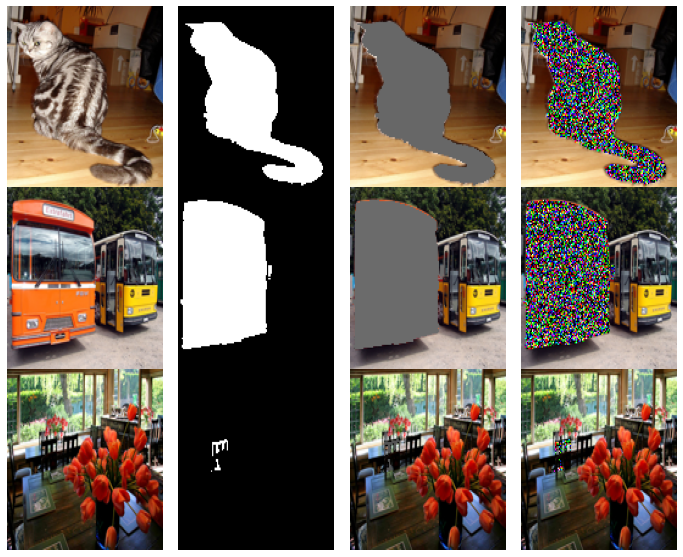

In [12]:
a,b,c = testset(3)
show_result(a,b,c,torch.randn((3,3,128,128)))

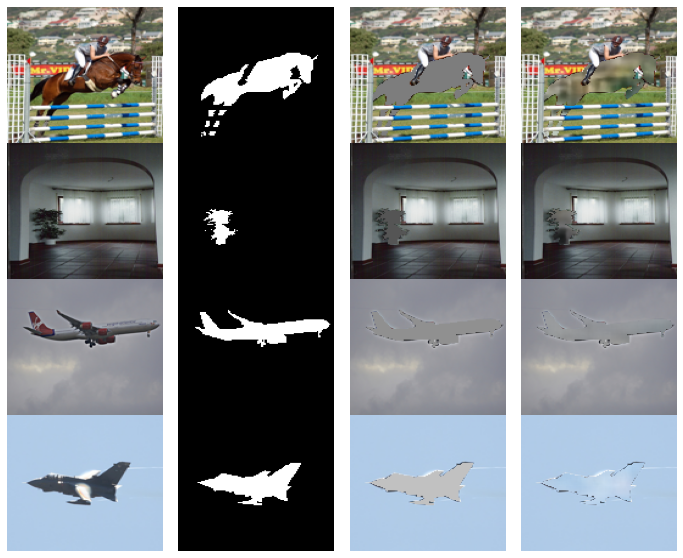

In [17]:
model = ContextEncoder()
model.load_state_dict(torch.load("/content/drive/My Drive/Inpainting/result/CE_recent.pth",map_location=device))

original, mask, masked = testset(4)
model.eval() #필수적이다. 그렇지 않으면 batch norm에 의해 간섭
result = model(masked)

show_result(original,mask,masked,result)